# Financial Phrase Bank dataset

In [1]:
import sys
sys.path.append('../')
import torch
import numpy as np
import utils

In [ ]:
from model import Model
from dataset_class import FPBDataset
from evaluation import EvaluationClassification
import estimators
import acquisition
import metrics
import visualize
import ase

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
prompt = f"""Classify the sentiment of the following sentence as "negative", "neutral" or "positive". Respond with "negative", "neutral" or "positive".\n"""

In [4]:
dataset_file = 'fpb'

## LLaMa2 70B

In [7]:
model_file = "llama2_70b"

In [ ]:
llama = Model(model_name="Llama-2-70b",
                    model_file=model_file,
                    dataset_file=dataset_file,
                    prompt=prompt,
                    device=device)

In [9]:
fpb_dataset = FPBDataset(dataset_file)
fpb_dataset.load(llama.prompt, llama.model.tokenizer, device)

In [10]:
llama_evaluation = EvaluationClassification(llama,
                                            fpb_dataset,
                                            device)

In [12]:
llama_evaluation.evaluation_procedure("active", batch_size=10, save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:56<00:00,  1.78s/it]

Accuracy: 0.26249998807907104 - Loss: 1.3122650384902954


In [17]:
llama_evaluation.evaluation_icl_procedure("active", nb_icl_examples=50, batch_size=1, save=True, version=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:07:20<00:00,  2.02s/it]

Accuracy: 0.9415000081062317 - Loss: 0.21521182358264923


## Llama2 7B

In [ ]:
model_file = "llama2_7b"

In [ ]:
llama = Model(model_name="Llama-2-7b-8bit",
            model_file=model_file,
            dataset_file=dataset_file,
            prompt=prompt,
            device=device)

In [ ]:
fpb_dataset = FPBDataset(dataset_file)
fpb_dataset.load(llama.prompt, llama.model.tokenizer, device)

In [9]:
llama_evaluation = EvaluationClassification(llama,
                                            fpb_dataset,
                                            device)

In [ ]:
llama_evaluation.evaluation_procedure("active", batch_size=1, save=True)

In [13]:
llama_evaluation.evaluation_icl_procedure("active", nb_icl_examples=50, batch_size=1, save=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [28:39<00:00,  1.16it/s]

Accuracy: 0.8955000042915344 - Loss: 0.3099234700202942


## Acquisition

In [5]:
STEP = 1
RUNS = 3_000
SIZE = 400

### LURE-based Active Testing

In [7]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            temperature=None)
llama_acquisition.run_estimation(clip_percentage=0.1)

100%|██████████| 3000/3000 [03:34<00:00, 13.97it/s]


In [8]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                                    runs=1000,
                                                                    size=SIZE,
                                                                    eps=1e-15,
                                                                    model_file='llama2_70b_icl50',
                                                                    surrogate_file='llama2_7b_icl50',
                                                                    dataset_file=dataset_file,
                                                                    loss=metrics.cross_entropy_loss,
                                                                    temperature=None)
llama_acquisition.get_coverage_estimation(100)

100%|██████████| 100/100 [1:07:31<00:00, 40.52s/it]


### Active testing with no weight (naive)

In [ ]:
llama_acquisition = acquisition.SurrogateEntropyAcquisition(step=STEP,
                                                            runs=RUNS,
                                                            size=SIZE,
                                                            eps=1e-15,
                                                            model_file='llama2_70b_icl50',
                                                            surrogate_file="llama2_7b_icl50",
                                                            dataset_file=dataset_file,
                                                            loss=metrics.cross_entropy_loss,
                                                            estimator=estimators.iidEstimator,
                                                            temperature=None)
llama_acquisition.run_estimation(coverage_probability=0.1)

### I.I.D.

In [ ]:
llama_acquisition = acquisition.iidAcquisition(step=STEP,
                                                runs=RUNS,
                                                size=SIZE,
                                                eps=1e-15,
                                                model_file="llama2_70b_icl50",
                                                dataset_file=dataset_file,
                                                loss=metrics.cross_entropy_loss)
llama_acquisition.run_estimation()

### ASE

In [28]:
ase_estimator = ase.ActiveSurrogateEstimator(model_file="llama2_7b_icl50",
                                            surrogate_file="llama2_70b_icl50",
                                            dataset_file='fpb',
                                            loss=metrics.cross_entropy_loss)
ase_estimator.zero_shot_estimate()

## Figures

In [7]:
true_error = utils.load_tensors(f'fpb/llama2_70b_icl50/active_set_loss').numpy()

In [9]:
visualize.setup_matplotlib()

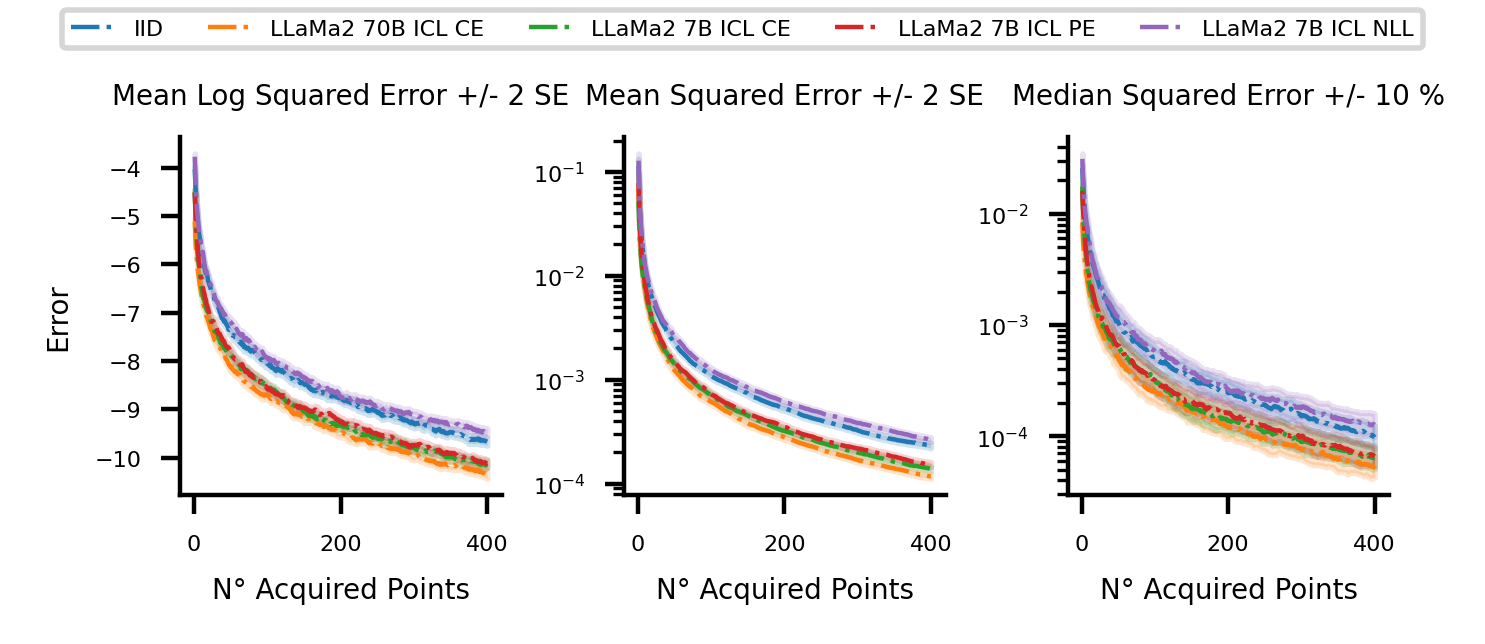

In [18]:
res_dict = {
    'IID': utils.load_arrays('fpb/llama2_70b_icl50/llama2_70b_icl50_iid_loss'),
    'LLaMa2 70B ICL CE': utils.load_arrays('fpb/llama2_70b_icl50/llama2_70b_icl50_llama2_70b_icl50_loss'), 
    'LLaMa2 7B ICL CE': utils.load_arrays('fpb/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss'), 
    'LLaMa2 7B ICL PE': utils.load_arrays('fpb/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_entropy'), 
    'LLaMa2 7B ICL NLL': utils.load_arrays('fpb/llama2_70b_icl50/llama2_70b_icl50_llama2_7b_icl50_loss_nll'), 
}
visualize.plot_all_errors(res_dict, true_error, STEP, title='', savefig=(False, ''))